# LayoutLMv3 for Legal Document Analysis

This notebook implements a streamlined pipeline for using LayoutLMv3 to analyze legal documents. The code leverages the existing Python scripts from the repository.

1. **Setup Environment**: Configure the runtime environment (local or Colab)
2. **Data Preparation**: If needed, prepare the CUAD dataset for LayoutLMv3
3. **Model Training**: Fine-tune LayoutLMv3 for legal document understanding
4. **Inference**: Apply the trained model to new documents

This notebook assumes you already have the processor files set up in the `layoutlmv3/processor` directory.

## 1. Setup Environment

First, let's set up the environment. When running in Google Colab, we'll mount Google Drive to access and save files. Skip this if running locally.

### 1.1 Check Environment and Setup Google Drive (for Colab)

First, we'll check if we're in Colab and set up Google Drive access if needed.

In [3]:
# Check if running in Colab
import sys
import os
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab environment")
    from google.colab import drive
    drive.mount('/content/drive')

    # Set and change to base path
    base_path = "/content/drive/MyDrive/law bundling POC"
    os.chdir(base_path)

    print("Working directory set to:", os.getcwd())
else:
    print("Running in local environment")
    # Optional local setup
    base_path = r"C:\freelance\Leon\law bundling POC"  # Using raw string
    # OR
    # base_path = "C:/freelance/Leon/law bundling POC/layoutlmv3"  # Using forward slashes
    # OR
    # base_path = "C:\\freelance\\Leon\\law bundling POC\\layoutlmv3"  # Using escaped backslashes
    os.chdir(base_path)
    print("Working directory set to:", os.getcwd())

Running in local environment


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\freelance\\Leon\\law bundling POC'

In [ ]:
!ls CUAD_v1/

'ls' is not recognized as an internal or external command,
operable program or batch file.


^C


### 1.2 Install Required Packages

Now let's install all the dependencies needed for the project (if not already installed).

In [4]:
# Install required packages
# If you already have these packages installed, you can skip this step
!pip install torch transformers pdf2image pillow matplotlib opencv-python tqdm scikit-learn pandas paddlepaddle paddleocr

# or !pip install -r layoutlmv3/requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!apt-get update
!apt-get install -y poppler-utils

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!which pdfinfo

/usr/bin/pdfinfo


In [ ]:
# Basic listing of files and directories - linux
# !ls

#windows
!dir

 Volume in drive C has no label.
 Volume Serial Number is DC6B-7916

 Directory of c:\freelance\Leon\law bundling POC\layoutlmv3

05/04/2025  07:06 PM    <DIR>          .
05/04/2025  07:06 PM    <DIR>          ..
05/04/2025  07:06 PM            37,323 annotate.py
03/04/2025  06:03 PM             5,922 dataset.py
03/04/2025  06:03 PM             7,699 debug_environment.py
05/04/2025  02:24 AM            29,552 inference.py
03/04/2025  07:06 PM            21,837 notebook.ipynb
05/04/2025  07:40 PM           121,479 notebook_v2.ipynb
03/04/2025  06:03 PM             7,869 prepare_dataset.py
03/04/2025  06:03 PM    <DIR>          processor
03/04/2025  06:03 PM             8,510 README.md
03/04/2025  06:03 PM               215 requirements.txt
03/04/2025  06:03 PM             2,335 setup_processor.py
05/04/2025  12:13 AM            12,842 train.py
03/04/2025  06:03 PM             9,422 validate_annotations.py
              12 File(s)        265,005 bytes
               3 Dir(s)  44,404,711,

### 1.3 Verify Directory Structure

Let's verify the necessary directory structure exists for our project. If not, we'll create the missing directories.

In [1]:
import os

# Define the expected directory structure
directories = [
    "CUAD_v1/layoutlmv3",
    "CUAD_v1/layoutlmv3_dataset",
    "CUAD_v1/full_contract_pdf",
    "layoutlmv3/processor"
]

# Verify directories exist
missing_dirs = [d for d in directories if not os.path.exists(d)]
if missing_dirs:
    print(f"⚠️ Missing directories:")
    for d in missing_dirs:
        print(f"  - {d}")
else:
    print("✅ All necessary directories are present.")

# Define all required files (based on the screenshot)
required_files = [
    "layoutlmv3/annotate.py",
    "layoutlmv3/dataset.py",
    "layoutlmv3/debug_environment.py",
    "layoutlmv3/inference.py",
    "layoutlmv3/prepare_dataset.py",
    "layoutlmv3/requirements.txt",
    "layoutlmv3/setup_processor.py",
    "layoutlmv3/train.py",
    "layoutlmv3/validate_annotations.py"
]

# Verify the required files exist
missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print(f"⚠️ Missing {len(missing_files)} required files:")
    for f in missing_files:
        print(f"  - {f}")
else:
    print("✅ All required files are present.")


✅ All necessary directories are present.
✅ All required files are present.


### Download or Import CUAD Dataset

To use this notebook, you need the CUAD dataset. You can either download it directly or upload your own files.

**Option 1: Download CUAD dataset** (Note: The dataset is quite large)

In [ ]:
# This cell is optional - Run if you need to download the CUAD dataset
# Uncomment the following lines if you want to download

# Download CUAD dataset (Note: This is a large download ~ 800MB)
# !wget -q https://www.atticusprojectai.org/cuad/CUAD_v1.zip
# !unzip -q CUAD_v1.zip
# !mv CUAD_v1/* CUAD_v1/
# TODO: make sure the paths are correct
print("If you already have the CUAD dataset, please make sure the files are organized in the CUAD_v1 directory.")

**Option 2: Upload your own PDF files** (if you have a specific set of documents)

In [ ]:
# # This cell is optional - Run if you're uploading your own documents
# # Only run if using Colab and you want to upload PDFs manually

# if IN_COLAB:
#     from google.colab import files

#     print("Upload your PDF files (you can select multiple files):")
#     uploaded = files.upload()

#     # Move uploaded files to the appropriate directory
#     for filename in uploaded.keys():
#         destination = f"CUAD_v1/full_contract_pdf/{filename}"
#         !cp "{filename}" "{destination}"
#         print(f"Moved {filename} to {destination}")
# else:
#     print("In local environment, please manually place your PDF files in the CUAD_v1/full_contract_pdf directory.")

## 2. Data Annotation and Preparation

The first step is to annotate the PDF documents and extract spatial information for the text. Then, we'll prepare these annotations for training with LayoutLMv3.

### 2.1 Document Annotation

The annotation process uses OCR to identify text locations in PDFs and aligns this with the CUAD annotations.

**Note:** This step can be time-consuming. If you have already generated annotations, you can skip this step.

In [ ]:
# Run document annotation
# This process might take several hours depending on dataset size
# Uncomment the following lines if you want to run the annotation process
# limit: the amount of documents

!python layoutlmv3/annotate.py --target-part="Part_I" --num-dirs=13 --skip-existing
# Check if annotations exist
if os.path.exists("CUAD_v1/layoutlmv3"):
    annotation_files = [f for f in os.listdir("CUAD_v1/layoutlmv3") if f.endswith('_layoutlm.json')]
    if annotation_files:
        print(f"Found {len(annotation_files)} existing annotation files in CUAD_v1/layoutlmv3")
    else:
        print("No annotation files found. You may need to run the annotation process.")
else:
    print("Annotation directory not found. Please run the annotation process or provide pre-annotated files.")

In [5]:
import os
import json

# Define paths
CUAD_DIR = "CUAD_v1/"
PDF_DIR = os.path.join(CUAD_DIR, "full_contract_pdf")
ANNOTATION_DIR = os.path.join(CUAD_DIR, "layoutlmv3")
TARGET_PART = "Part_I"
NUM_DIRS = 13

def find_target_pdfs():
    """Find all PDFs that should have been annotated based on target part and num_dirs"""
    pdf_files = []
    part_path = os.path.join(PDF_DIR, TARGET_PART)
    
    if not os.path.exists(part_path):
        print(f"Warning: {part_path} does not exist")
        return pdf_files
    
    # Get all subdirectories in the part
    subdirs = [d for d in os.listdir(part_path) 
              if os.path.isdir(os.path.join(part_path, d))]
    
    # Sort them and take first NUM_DIRS
    subdirs.sort()
    target_dirs = subdirs[:NUM_DIRS]
    
    print(f"Checking files from {TARGET_PART}: {len(target_dirs)} directories - {target_dirs}")
    
    # Find all PDFs in these directories
    for subdir in target_dirs:
        subdir_path = os.path.join(part_path, subdir)
        for file in os.listdir(subdir_path):
            if file.endswith(".pdf"):
                pdf_path = os.path.join(subdir_path, file)
                pdf_files.append(pdf_path)
    
    return pdf_files

def check_annotations():
    """Check if all target PDFs have corresponding annotation files"""
    pdf_files = find_target_pdfs()
    
    if not pdf_files:
        print("No PDF files found to check")
        return
    
    total_pdfs = len(pdf_files)
    annotated_pdfs = 0
    missing_annotations = []
    
    for pdf_path in pdf_files:
        pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
        annotation_path = os.path.join(ANNOTATION_DIR, f"{pdf_name}_layoutlm.json")
        
        if os.path.exists(annotation_path):
            # Check if the annotation file has valid content
            try:
                with open(annotation_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    if 'annotations' in data and len(data['annotations']) > 0:
                        annotated_pdfs += 1
                    else:
                        missing_annotations.append(pdf_path)
                        print(f"⚠️ Empty annotations for: {pdf_name}")
            except:
                missing_annotations.append(pdf_path)
                print(f"❌ Invalid annotation file for: {pdf_name}")
        else:
            missing_annotations.append(pdf_path)
            print(f"❌ Missing annotation for: {pdf_name}")
    
    completion_rate = (annotated_pdfs / total_pdfs) * 100 if total_pdfs > 0 else 0
    
    print("\n=== Annotation Status ===")
    print(f"Total PDFs to annotate: {total_pdfs}")
    print(f"Successfully annotated: {annotated_pdfs}")
    print(f"Missing annotations: {total_pdfs - annotated_pdfs}")
    print(f"Completion rate: {completion_rate:.2f}%")
    
    if missing_annotations:
        print("\nPDFs still needing annotation:")
        for i, pdf_path in enumerate(missing_annotations[:10], 1):
            print(f"{i}. {os.path.basename(pdf_path)}")
        
        if len(missing_annotations) > 10:
            print(f"... and {len(missing_annotations) - 10} more")
    else:
        print("\n✅ All PDFs have been successfully annotated!")

# Run the check
check_annotations()

Checking files from Part_I: 13 directories - ['Affiliate_Agreements', 'Co_Branding', 'Development', 'Distributor', 'Endorsement', 'Franchise', 'Hosting', 'IP', 'Joint Venture', 'License_Agreements', 'Maintenance', 'Manufacturing', 'Marketing']
❌ Missing annotation for: HarpoonTherapeuticsInc_20200312_10-K_EX-10.18_12051356_EX-10.18_Development Agreement_Option Agreement
⚠️ Empty annotations for: ArmstrongFlooringInc_20190107_8-K_EX-10.2_11471795_EX-10.2_Intellectual Property Agreement
⚠️ Empty annotations for: CerenceInc_20191002_8-K_EX-10.4_11827494_EX-10.4_Intellectual Property Agreement
⚠️ Empty annotations for: GarrettMotionInc_20181001_8-K_EX-2.4_11364532_EX-2.4_Intellectual Property Agreement
⚠️ Empty annotations for: RareElementResourcesLtd_20171019_SC 13D_EX-99.4_10897534_EX-99.4_Intellectual Property Agreement
⚠️ Empty annotations for: AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293_EX-10.19_Content License Agreement
⚠️ Empty annotations for: ArconicRolledProducts

### 2.2 Prepare Dataset for LayoutLMv3 - Run this only if we need to prepare the dataset for the first time

Next, we'll convert the annotated documents into the format expected by LayoutLMv3 and split them into training, validation, and test sets.

In [4]:
# Check if dataset already exists
dataset_exists = False
if os.path.exists("CUAD_v1/layoutlmv3_dataset"):
    for split in ["train", "val", "test"]:
        split_dir = f"CUAD_v1/layoutlmv3_dataset/{split}"
        if os.path.exists(split_dir) and len(os.listdir(split_dir)) > 0:
            dataset_exists = True
            break #break if the splits already existed

if dataset_exists:
    print("Dataset already prepared. Skipping dataset preparation step.")
    # Show dataset statistics
    for split in ["train", "val", "test"]:
        split_dir = f"CUAD_v1/layoutlmv3_dataset/{split}"
        if os.path.exists(split_dir):
            files = os.listdir(split_dir)
            images = [f for f in files if f.endswith('.jpg')]
            annotations = [f for f in files if f.endswith('.json')]
            print(f"{split.capitalize()} set: {len(images)} images, {len(annotations)} annotation files")
else:
    print("Dataset not found. Running dataset preparation...")
    # Run dataset preparation
    !python layoutlmv3/prepare_dataset.py

    # Verify dataset was created
    if os.path.exists("CUAD_v1/layoutlmv3_dataset"):
        for split in ["train", "val", "test"]:
            split_dir = f"CUAD_v1/layoutlmv3_dataset/{split}"
            if os.path.exists(split_dir):
                files = os.listdir(split_dir)
                images = [f for f in files if f.endswith('.jpg')]
                annotations = [f for f in files if f.endswith('.json')]
                print(f"{split.capitalize()} set: {len(images)} images, {len(annotations)} annotation files")
    else:
        print("Dataset preparation failed. Please check the logs for errors.")

Dataset not found. Running dataset preparation...
Preparing dataset for LayoutLMv3 fine-tuning...
Splitting dataset: 105 train, 22 validation, 24 test
Processing training set...
No annotations found in CUAD_v1/layoutlmv3\CardlyticsInc_20180112_S-1_EX-10.16_11002987_EX-10.16_Maintenance Agreement1_layoutlm.json
No annotations found in CUAD_v1/layoutlmv3\LejuHoldingsLtd_20140121_DRS (on F-1)_EX-10.26_8473102_EX-10.26_Content License Agreement1_layoutlm.json
No annotations found in CUAD_v1/layoutlmv3\WebmdHealthCorp_20050908_S-1A_EX-10.7_1027007_EX-10.7_Content License Agreement_layoutlm.json
No annotations found in CUAD_v1/layoutlmv3\AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293_EX-10.19_Content License Agreement_layoutlm.json
No annotations found in CUAD_v1/layoutlmv3\PlayboyEnterprisesInc_20090220_10-QA_EX-10.2_4091580_EX-10.2_Content License Agreement_ Marketing Agreement_ Sales-Purchase Agreement1_layoutlm.json
No annotations found in CUAD_v1/layoutlmv3\BloomEnergyCorp


100%|██████████| 105/105 [11:09<00:00,  6.38s/it]

100%|██████████| 22/22 [02:48<00:00,  7.64s/it]

100%|██████████| 24/24 [02:37<00:00,  6.57s/it]


## 3. Model Training

In this section, we'll train the LayoutLMv3 model on our prepared dataset. We'll skip the processor setup since you already have the processor configured in your environment.

### 3.1 Verify Processor Configuration

First, let's verify that the processor is already set up correctly before proceeding to training.

In [4]:
# Check your processor directory to make sure it's properly set up
import os
if os.path.exists("layoutlmv3/processor/tokenizer_config.json") and \
   os.path.exists("layoutlmv3/processor/preprocessor_config.json"):
    print("Processor is already set up and ready to use!")
    # List processor files
    processor_files = os.listdir("layoutlmv3/processor")
    print(f"Processor files: {processor_files}")
else:
    print("Processor may not be properly configured. You might need to run setup_processor.py first.")

Processor is already set up and ready to use!
Processor files: ['merges.txt', 'preprocessor_config.json', 'processor_settings.txt', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json']


### 3.2 Train the Model

Now we'll train LayoutLMv3 on our prepared dataset, using the existing processor. This process will take several hours depending on the size of the dataset and your hardware capabilities.

In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# For more detailed GPU information if available
if device == "cuda":
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU Model: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.59 GB


In [1]:
# if the training is new, just run 
# !python layoutlmv3/train.py --num_epochs 25 --batch_size 2 --learning_rate 5e-5

# if wanna resume from previous training just:
# Where [previous_timestamp] should be replaced with the timestamp of your previous training run's output directory. If you're not sure what that is, you can check inside the layoutlmv3/model/ directory to see the available training run folders.
# !python layoutlmv3/train.py --num_epochs 1 --batch_size 2 --learning_rate 5e-5 --resume_from layoutlmv3/model/train-20250408_100352

# Uncomment and run this cell to start training
!python layoutlmv3/train.py --num_epochs 100 --batch_size 4 --learning_rate 5e-6 --early_stopping


Early stopping enabled with patience=3, min_delta=0.0001
Training started at: 2025-04-18 21:28:59
Parameters: {'dataset_dir': 'CUAD_v1/layoutlmv3_dataset', 'output_dir': 'layoutlmv3/model/train-20250418_212859', 'model_name': 'microsoft/layoutlmv3-base', 'processor_dir': None, 'batch_size': 4, 'learning_rate': 5e-06, 'num_epochs': 100, 'max_seq_length': 512, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'save_steps': 100, 'eval_steps': 100, 'checkpoint_steps': 500, 'seed': 42, 'device': 'cuda', 'num_workers': 0, 'resume_from': None, 'early_stopping': True, 'patience': 3, 'min_delta': 0.0001}
Loading model microsoft/layoutlmv3-base...
Creating new processor with OCR disabled...
Saving processor to layoutlmv3/model/train-20250418_212859\processor...
Creating data loaders (batch_size=4, num_workers=0)...
Loaded 193 examples from CUAD_v1/layoutlmv3_dataset\train
Loaded 55 examples from CUAD_v1/layoutlmv3_dataset\val
Starting/Resuming training with 4900 total steps...
Epoch 1/100
Epoch 1 avera

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training (Epoch 1):   0%|          | 0/49 [00:00<?, ?it/s]d:\JOBS\JUSBUNDLE\law-bundling-POC\venv\Lib\site-packages\transformers\modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(

Training (Epoch 1): 100%|██████████| 49/49 [02:16<00:00,  2.79s/it]

Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
d:\JOBS\JUSBUNDLE\law-bundling-POC\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [ ]:
# if the training is new, just run 
# !python layoutlmv3/train.py --num_epochs 25 --batch_size 2 --learning_rate 5e-5

# if wanna resume from previous training just:
# Where [previous_timestamp] should be replaced with the timestamp of your previous training run's output directory. If you're not sure what that is, you can check inside the layoutlmv3/model/ directory to see the available training run folders.
# !python layoutlmv3/train.py --num_epochs 1 --batch_size 2 --learning_rate 5e-5 --resume_from layoutlmv3/model/train-20250408_100352

# Uncomment and run this cell to start training
!python layoutlmv3/train.py --num_epochs 100 --batch_size 2 --learning_rate 5e-5


Training started at: 2025-04-18 12:41:56
Parameters: {'dataset_dir': 'CUAD_v1/layoutlmv3_dataset', 'output_dir': 'layoutlmv3/model/train-20250418_124156', 'model_name': 'microsoft/layoutlmv3-base', 'processor_dir': None, 'batch_size': 2, 'learning_rate': 5e-05, 'num_epochs': 100, 'max_seq_length': 512, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'save_steps': 100, 'eval_steps': 100, 'checkpoint_steps': 500, 'seed': 42, 'device': 'cuda', 'num_workers': 0, 'resume_from': None}
Loading model microsoft/layoutlmv3-base...
Creating new processor with OCR disabled...
Saving processor to layoutlmv3/model/train-20250418_124156\processor...
Creating data loaders (batch_size=2, num_workers=0)...
Loaded 193 examples from CUAD_v1/layoutlmv3_dataset\train
Loaded 55 examples from CUAD_v1/layoutlmv3_dataset\val
Starting/Resuming training with 9700 total steps...
Epoch 1/100
Epoch 1 average loss: 3.6123
Evaluating after epoch 1...
Evaluation results: {'precision': 0.028472307563694423, 'recall': 0.11511

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training (Epoch 1):   0%|          | 0/97 [00:00<?, ?it/s]d:\JOBS\JUSBUNDLE\law-bundling-POC\venv\Lib\site-packages\transformers\modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(

Training (Epoch 1): 100%|██████████| 97/97 [00:27<00:00,  3.51it/s]

Evaluating: 100%|██████████| 28/28 [00:07<00:00,  3.51it/s]
d:\JOBS\JUSBUNDLE\law-bundling-POC\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

: 

In [ ]:
# if the training is new, just run 
# !python layoutlmv3/train.py --num_epochs 25 --batch_size 2 --learning_rate 5e-5

# if wanna resume from previous training just:
# Where [previous_timestamp] should be replaced with the timestamp of your previous training run's output directory. If you're not sure what that is, you can check inside the layoutlmv3/model/ directory to see the available training run folders.
# !python layoutlmv3/train.py --num_epochs 1 --batch_size 2 --learning_rate 5e-5 --resume_from layoutlmv3/model/train-20250408_100352

# Uncomment and run this cell to start training
!python layoutlmv3/train.py --num_epochs 100 --batch_size 2 --learning_rate 5e-6


### 3.3 Check Training Results

Let's check if the training was successful and the model was saved properly.

In [ ]:
!ls -la layoutlmv3/model/train-20250404_165409/best_model/
!ls -la layoutlmv3/model/train-20250404_165409/final_model/

total 492018
-rw------- 1 root root      2706 Apr  4 16:55 config.json
-rw------- 1 root root 503822716 Apr  4 16:55 model.safetensors
total 492018
-rw------- 1 root root      2706 Apr  4 17:08 config.json
-rw------- 1 root root 503822716 Apr  4 17:08 model.safetensors


In [3]:
import os
import glob

# Find the most recent training directory
# train_dirs = sorted(glob.glob("layoutlmv3/model/train-*"), reverse=True)
train_dirs = sorted(glob.glob("layoutlmv3/model/batch-2"), reverse=True)

if train_dirs:
    latest_train_dir = train_dirs[0]
    print(f"Found latest training directory: {latest_train_dir}")

    # Check if best model exists (looking for safetensors format)
    best_model_path = os.path.join(latest_train_dir, "best_model/model.safetensors")
    if os.path.exists(best_model_path):
        print("Training completed successfully! Best model was saved.")
        # List model files
        model_files = os.listdir(os.path.join(latest_train_dir, "best_model"))
        print(f"Model files: {model_files}")

        # Check if metrics history exists
        metrics_path = os.path.join(latest_train_dir, "metrics_history.json")
        if os.path.exists(metrics_path):
            print("Training metrics were saved. You can use them for analysis.")

        # Check if log file exists
        log_path = os.path.join(latest_train_dir, "training_log.txt")
        if os.path.exists(log_path):
            print("\nLast few lines from training log:")
            # Display the last 10 lines of the log file
            with open(log_path, "r") as f:
                log_lines = f.readlines()
                for line in log_lines[-10:]:
                    print(line.strip())
    else:
        print("Best model not found in the latest training directory.")

        # Check if final model exists
        final_model_path = os.path.join(latest_train_dir, "final_model/model.safetensors")
        if os.path.exists(final_model_path):
            print("Final model was saved, but it wasn't the best during training.")
            print(f"You can find it at: {os.path.join(latest_train_dir, 'final_model')}")
        else:
            print("Neither best nor final models were found. Training may have failed.")

        # Check if log file exists for debugging
        log_path = os.path.join(latest_train_dir, "training_log.txt")
        if os.path.exists(log_path):
            print("\nLast few lines from training log (might help diagnose issues):")
            # Display the last 10 lines of the log file
            with open(log_path, "r") as f:
                log_lines = f.readlines()
                for line in log_lines[-50:]:
                    print(line.strip())
else:
    print("No training directories found at layoutlmv3/model/train-*")

    # Fallback to check the old directory structure
    if os.path.exists("layoutlmv3/model/best_model/model.safetensors") or os.path.exists("layoutlmv3/model/best_model/pytorch_model.bin"):
        print("Found model in the old directory structure.")
        print("Training completed successfully! Best model was saved.")
        # List model files
        model_files = os.listdir("layoutlmv3/model/best_model")
        print(f"Model files: {model_files}")
    else:
        print("No trained models found. Please run training first.")

Found latest training directory: layoutlmv3/model/batch-2
Training completed successfully! Best model was saved.
Model files: ['config.json', 'model.safetensors']
Training metrics were saved. You can use them for analysis.

Last few lines from training log:
Saving checkpoint at step 2000...
Epoch 25 average loss: 0.1886
Evaluating after epoch 25...
Evaluation results: {'precision': 0.2366543309104966, 'recall': 0.20506329113924052, 'f1': 0.19772235903367338}
Saving checkpoint at end of epoch 25...
Training complete. Saving final model...
Best F1: 0.2261
Model saved to layoutlmv3/model/train-20250408_093030
Training completed at: 2025-04-08 09:48:35
Generating training visualizations...


### 3.4 Check Training Logs


In [15]:
import os
import glob

# Find the most recent training directory
train_dirs = sorted(glob.glob("layoutlmv3/model/train-*"), reverse=True)

if train_dirs:
    latest_train_dir = train_dirs[0]
    print(f"Latest training directory: {latest_train_dir}")

    # Path to the training log
    log_path = os.path.join(latest_train_dir, "training_log.txt")

    if os.path.exists(log_path):
        print(f"Found training log at: {log_path}")

        # Option 1: Print the entire log
        # with open(log_path, "r") as f:
        #     print(f.read())

        # Option 2: Print the last N lines (useful for long logs)
        num_lines = 50  # Adjust this number to see more or fewer lines
        with open(log_path, "r") as f:
            lines = f.readlines()

        print(f"\n=== Last {min(num_lines, len(lines))} lines of training log ===\n")
        for line in lines[-num_lines:]:
            print(line.strip())
    else:
        print(f"No training log found at {log_path}")
else:
    print("No training directories found.")

Latest training directory: layoutlmv3/model\train-20250406_131014
Found training log at: layoutlmv3/model\train-20250406_131014\training_log.txt

=== Last 50 lines of training log ===

Evaluating after epoch 19...
Evaluation results: {'precision': 0.17688130183801462, 'recall': 0.13544303797468354, 'f1': 0.1374170290957758}
Epoch 20/25
Step 1600/2000 - Loss: 0.0125

Evaluating at step 1600...
Evaluation results: {'precision': 0.17428285402760438, 'recall': 0.14177215189873418, 'f1': 0.1412362671978745}
Epoch 20 average loss: 0.2492
Evaluating after epoch 20...
Evaluation results: {'precision': 0.17428285402760438, 'recall': 0.14177215189873418, 'f1': 0.1412362671978745}
Epoch 21/25
Epoch 21 average loss: 0.2112
Evaluating after epoch 21...
Evaluation results: {'precision': 0.17206196590440426, 'recall': 0.13037974683544304, 'f1': 0.13269565271396982}
Epoch 22/25
Step 1700/2000 - Loss: 0.0025

Evaluating at step 1700...
Evaluation results: {'precision': 0.16137346827837346, 'recall': 0.

# Visulization
You can visualize the results by running the following code:

Found latest training directory: layoutlmv3/model\train-20250408_100352
Determined there are approximately 76 steps per epoch
Parsing training log at layoutlmv3/model\train-20250408_100352\training_log.txt to extract metrics...


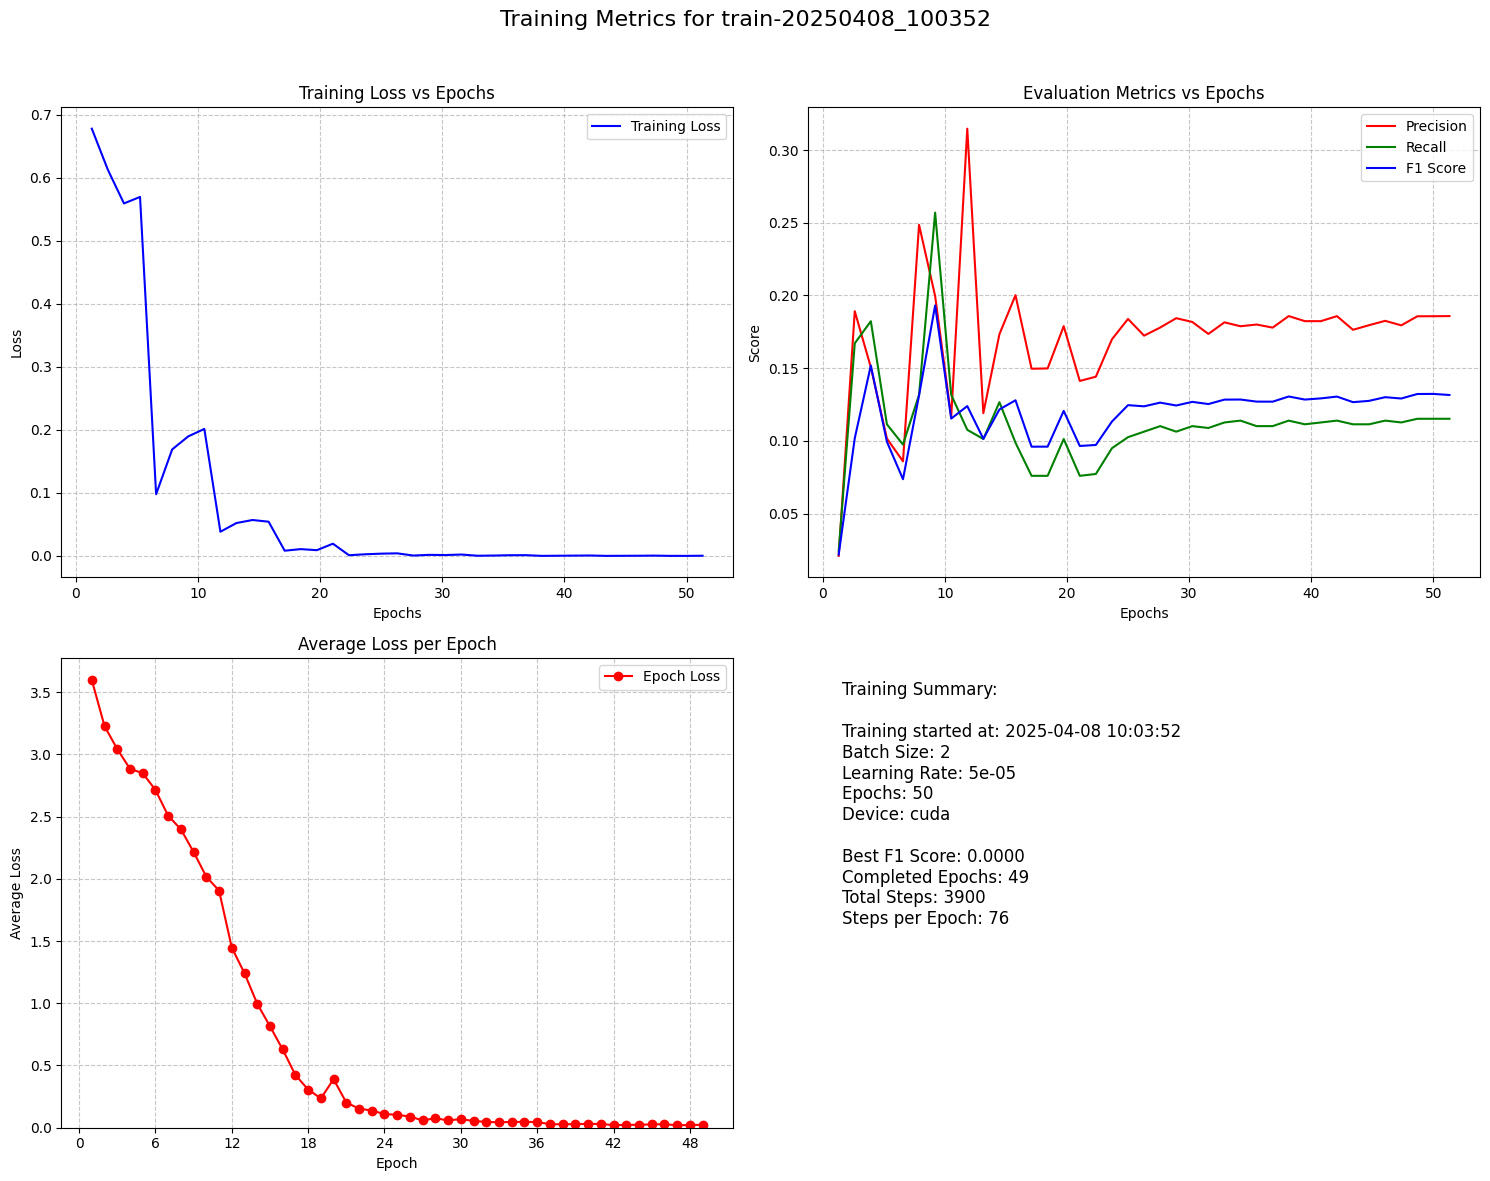

In [12]:
import os
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Find the most recent training directory
train_dirs = sorted(glob.glob("layoutlmv3/model/train-*"), reverse=True)

if not train_dirs:
    print("No training directories found.")
else:
    latest_train_dir = train_dirs[0]
    print(f"Found latest training directory: {latest_train_dir}")
    
    # Try to find the metrics history file
    metrics_path = os.path.join(latest_train_dir, "metrics_history.json")
    log_path = os.path.join(latest_train_dir, "training_log.txt")
    
    # Extract information about steps per epoch from the log
    steps_per_epoch = None
    num_epochs = None
    
    if os.path.exists(log_path):
        with open(log_path, "r") as f:
            for line in f:
                if "Parameters:" in line:
                    try:
                        params_str = line.split("Parameters:")[1].strip()
                        params = eval(params_str)
                        num_epochs = params.get('num_epochs', 25)
                        batch_size = params.get('batch_size', 2)
                    except:
                        pass
                
                # Look for total steps information
                if "Starting training with" in line and "steps" in line:
                    try:
                        total_steps = int(line.split("with ")[1].split(" ")[0])
                        if num_epochs:
                            steps_per_epoch = total_steps / num_epochs
                    except:
                        pass
    
    # If we couldn't determine steps_per_epoch from the log, try to infer it
    if not steps_per_epoch and os.path.exists(log_path):
        step_values = []
        with open(log_path, "r") as f:
            for line in f:
                if "Step " in line and " - Loss: " in line:
                    try:
                        step_value = int(line.strip().split("Step ")[1].split("/")[0])
                        step_values.append(step_value)
                    except:
                        pass
        
        if step_values:
            # Sort and find differences between consecutive step reports
            sorted_steps = sorted(step_values)
            if len(sorted_steps) > 1:
                # Most common difference is likely the evaluation frequency
                diffs = [sorted_steps[i+1] - sorted_steps[i] for i in range(len(sorted_steps)-1)]
                if diffs:
                    most_common_diff = max(set(diffs), key=diffs.count)
                    steps_per_epoch = most_common_diff * len(diffs) / num_epochs
    
    # If we still couldn't determine it, use the fact that there were 20 evaluation steps over 25 epochs
    if not steps_per_epoch:
        steps_per_epoch = 80  # 2000 steps / 25 epochs = 80 steps per epoch
    
    print(f"Determined there are approximately {steps_per_epoch:.0f} steps per epoch")
    
    # Initialize data structures to hold metrics
    steps = []
    loss_values = []
    eval_f1 = []
    eval_precision = []
    eval_recall = []
    epochs = []
    epoch_loss = []
    
    # Parse the training log to extract metrics
    if os.path.exists(log_path):
        print(f"Parsing training log at {log_path} to extract metrics...")
        
        with open(log_path, "r") as f:
            for line in f:
                # Extract step and loss
                if "Step " in line and " - Loss: " in line:
                    try:
                        parts = line.strip().split(" - Loss: ")
                        step_part = parts[0].split("Step ")[1].split("/")[0]
                        step = int(step_part)
                        loss = float(parts[1])
                        steps.append(step)
                        loss_values.append(loss)
                    except:
                        pass
                
                # Extract evaluation metrics
                if "Evaluation results" in line and "precision" in line:
                    try:
                        # The line looks like: Evaluation results: {'precision': 0.166, 'recall': 0.139, 'f1': 0.136}
                        metrics_str = line.split("Evaluation results: ")[1]
                        metrics = eval(metrics_str)  # Use eval to convert string to dictionary
                        
                        # If we just recorded a step, this is a step evaluation
                        if steps and (len(eval_f1) < len(steps)):
                            eval_precision.append(metrics['precision'])
                            eval_recall.append(metrics['recall'])
                            eval_f1.append(metrics['f1'])
                    except Exception as e:
                        print(f"Error parsing metrics: {e}")
                
                # Extract epoch information - FIXED PARSING
                if "Epoch " in line and "average loss:" in line:
                    try:
                        # The line format: "Epoch X average loss: Y.YYYY"
                        epoch_part = line.split("Epoch ")[1].split(" average")[0]
                        epoch_num = int(epoch_part)
                        loss_part = line.split("average loss: ")[1]
                        avg_loss = float(loss_part)
                        epochs.append(epoch_num)
                        epoch_loss.append(avg_loss)
                    except Exception as e:
                        print(f"Error parsing epoch loss (with better error handling): {line.strip()} - {str(e)}")
    
    # Convert steps to epochs for plotting
    steps_as_epochs = [step / steps_per_epoch for step in steps]
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle(f'Training Metrics for {os.path.basename(latest_train_dir)}', fontsize=16)
    
    # 1. Training Loss vs Epochs
    if steps and loss_values:
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.plot(steps_as_epochs, loss_values, 'b-', label='Training Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss vs Epochs')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Evaluation Metrics vs Epochs
    if steps and eval_f1 and len(steps) == len(eval_f1):
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.plot(steps_as_epochs, eval_precision, 'r-', label='Precision')
        ax2.plot(steps_as_epochs, eval_recall, 'g-', label='Recall')
        ax2.plot(steps_as_epochs, eval_f1, 'b-', label='F1 Score')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Score')
        ax2.set_title('Evaluation Metrics vs Epochs')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Epoch Average Loss
    if epochs and epoch_loss:
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.plot(epochs, epoch_loss, 'r-o', label='Epoch Loss')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Average Loss')
        ax3.set_title('Average Loss per Epoch')
        ax3.xaxis.set_major_locator(MaxNLocator(integer=True))  # Only show integer ticks for epochs
        ax3.legend()
        ax3.grid(True, linestyle='--', alpha=0.7)
        
        # Set y-axis to start from 0
        ax3.set_ylim(bottom=0)
    
    # 4. Best F1 Score Information
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.axis('off')  # No axes for this text display
    
    # Extract best F1 score
    best_f1 = 0
    with open(log_path, "r") as f:
        for line in f:
            if "Best F1:" in line:
                try:
                    best_f1 = float(line.split("Best F1:")[1].strip())
                except:
                    pass
    
    # Additional training info
    training_info = ""
    with open(log_path, "r") as f:
        first_line = f.readline().strip()
        if "Training started at:" in first_line:
            training_info += first_line + "\n"
        
        for line in f:
            if "Parameters:" in line:
                params_str = line.split("Parameters:")[1].strip()
                try:
                    params = eval(params_str)
                    # Format important parameters
                    training_info += f"Batch Size: {params.get('batch_size', 'N/A')}\n"
                    training_info += f"Learning Rate: {params.get('learning_rate', 'N/A')}\n"
                    training_info += f"Epochs: {params.get('num_epochs', 'N/A')}\n"
                    training_info += f"Device: {params.get('device', 'N/A')}\n"
                except:
                    training_info += "Could not parse parameters\n"
                break
    
    # Display training summary
    summary_text = f"Training Summary:\n\n"
    summary_text += f"{training_info}\n"
    summary_text += f"Best F1 Score: {best_f1:.4f}\n"
    
    if epochs:
        summary_text += f"Completed Epochs: {max(epochs)}\n"
    
    if steps:
        summary_text += f"Total Steps: {max(steps)}\n"
        summary_text += f"Steps per Epoch: {steps_per_epoch:.0f}\n"
    
    # Find training completion info
    with open(log_path, "r") as f:
        lines = f.readlines()
        for line in reversed(lines):
            if "Training completed at:" in line:
                summary_text += line.strip() + "\n"
                break
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, 
            fontsize=12, verticalalignment='top', wrap=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the title
    plt.show()

## 4. Inference and Evaluation

Now let's use our trained model to analyze new legal documents.

### 4.1 Upload or Select Test Document

First, let's select a PDF document to analyze. You can either use one from the test set or upload a new one.

In [ ]:
# Option 1: Upload a new PDF (for Colab)
if IN_COLAB:
    from google.colab import files

    print("Upload a PDF document for analysis:")
    uploaded = files.upload()

    if uploaded:
        test_pdf_path = list(uploaded.keys())[0]
        print(f"Selected PDF for analysis: {test_pdf_path}")
    else:
        print("No file uploaded. Please select an existing PDF.")
        test_pdf_path = None
else:
    # Option 2: Use an existing PDF
    # Find PDFs in the CUAD dataset
    pdf_dir = "CUAD_v1/full_contract_pdf"
    if os.path.exists(pdf_dir) and os.listdir(pdf_dir):
        pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')][:10]  # List first 10 files

        if pdf_files:
            print("Available PDFs for analysis:")
            for i, pdf in enumerate(pdf_files):
                print(f"{i+1}. {pdf}")

            # Select a PDF (you can change the index)
            selected_idx = 0  # SEE HERE!!!! Change this to select a different file
            test_pdf_path = os.path.join(pdf_dir, pdf_files[selected_idx])
            print(f"\nSelected PDF for analysis: {test_pdf_path}")
        else:
            print("No PDF files found in the dataset directory.")
            test_pdf_path = None
    else:
        print("PDF directory is empty or doesn't exist. Please add PDF files for analysis.")
        test_pdf_path = None

Upload a PDF document for analysis:


Saving CreditcardscomInc_20070810_S-1_EX-10.33_362297_EX-10.33_Affiliate Agreement.pdf to CreditcardscomInc_20070810_S-1_EX-10.33_362297_EX-10.33_Affiliate Agreement.pdf
Selected PDF for analysis: CreditcardscomInc_20070810_S-1_EX-10.33_362297_EX-10.33_Affiliate Agreement.pdf


# Check is poppler installed

In [ ]:
!pdfinfo "{test_pdf_path}"

Creator:         Aspose Ltd.
Producer:        Aspose.Pdf for .NET 17.6
ModDate:         Tue Mar 31 03:29:13 2020 UTC
Custom Metadata: no
Metadata Stream: yes
Tagged:          no
UserProperties:  no
Suspects:        no
Form:            none
JavaScript:      no
Pages:           12
Encrypted:       no
Page size:       595 x 842 pts (A4)
Page rot:        0
File size:       133922 bytes
Optimized:       no
PDF version:     1.4


### 4.2 Run Inference

Let's analyze the selected document with our trained model.

In [ ]:
import os
import glob

# Find the most recent training directory
train_dirs = sorted(glob.glob("layoutlmv3/model/train-*"), reverse=True)

if train_dirs:
    latest_train_dir = train_dirs[0]
    print(f"Found latest training directory: {latest_train_dir}")

    # Check if best model exists (looking for safetensors format)
    best_model_path = os.path.join(latest_train_dir, "best_model")
    model_exists = os.path.exists(os.path.join(best_model_path, "model.safetensors"))

    if not model_exists:
        # Check for final model if best model doesn't exist
        final_model_path = os.path.join(latest_train_dir, "final_model")
        if os.path.exists(os.path.join(final_model_path, "model.safetensors")):
            model_exists = True
            best_model_path = final_model_path
            print("Best model not found, using final model instead.")
else:
    # Fallback to check the old directory structure
    best_model_path = "layoutlmv3/model/best_model"
    model_exists = os.path.exists(os.path.join(best_model_path, "pytorch_model.bin")) or os.path.exists(os.path.join(best_model_path, "model.safetensors"))

if not model_exists:
    print("Warning: Trained model not found. You need to train the model first.")
    print("Check if any other model checkpoints exist that you could use instead:")

    # Look for models in timestamp directories
    all_models = []
    for train_dir in train_dirs:
        for model_subdir in ["best_model", "final_model"]:
            model_dir = os.path.join(train_dir, model_subdir)
            if os.path.exists(os.path.join(model_dir, "model.safetensors")) or os.path.exists(os.path.join(model_dir, "pytorch_model.bin")):
                all_models.append(model_dir)

    # Also check old directory structure
    for d in os.listdir("layoutlmv3/model"):
        model_dir = os.path.join("layoutlmv3/model", d)
        if os.path.isdir(model_dir) and (
            os.path.exists(os.path.join(model_dir, "pytorch_model.bin")) or
            os.path.exists(os.path.join(model_dir, "model.safetensors"))
        ):
            all_models.append(model_dir)

    if all_models:
        print(f"Found {len(all_models)} models: {all_models}")
        print("You could use one of these for inference by modifying the --model_dir parameter")
    else:
        print("No models found. Please train the model first.")

# Find processor directory
if train_dirs:
    processor_dir = latest_train_dir
else:
    processor_dir = "layoutlmv3/model"

# Run inference on the selected PDF if a model exists and a PDF is selected
if model_exists and test_pdf_path:
    print(f"Running inference using model: {best_model_path}")
    print(f"Using processor from: {processor_dir}")

    !python layoutlmv3/inference.py \
        --model_dir "{best_model_path}" \
        --processor_dir "{processor_dir}" \
        --pdf_path "{test_pdf_path}" \
        --output_dir layoutlmv3/results \
        --device {device} \
        --confidence_threshold 0.1

    # Check results
    pdf_name = os.path.splitext(os.path.basename(test_pdf_path))[0]
    # Sanitize the filename the same way as in inference.py
    safe_name = "".join(c for c in pdf_name if c.isalnum() or c in "._- ")
    results_dir = os.path.join("layoutlmv3/results", safe_name)

    if os.path.exists(results_dir):
        print(f"\nResults saved to {results_dir}")
        # List results files
        result_files = os.listdir(results_dir)
        print(f"Generated files: {result_files}")

        # Display summary if available
        summary_path = os.path.join(results_dir, "summary.txt")
        if os.path.exists(summary_path):
            print("\n=== ANALYSIS SUMMARY ===\n")
            with open(summary_path, "r") as f:
                summary = f.read()
                # Print the first 1000 characters of the summary
                print(summary[:1000] + "..." if len(summary) > 1000 else summary)
    else:
        print(f"Results directory not found: {results_dir}")
        # Try to find any directories that might have been created
        possible_dirs = glob.glob(f"layoutlmv3/results/*{pdf_name.split('_')[0]}*")
        if possible_dirs:
            print(f"Found possible result directories: {possible_dirs}")
elif test_pdf_path is None:
    print("No PDF selected for analysis.")

Found latest training directory: layoutlmv3/model/train-20250404_165409
Running inference using model: layoutlmv3/model/train-20250404_165409/best_model
Using processor from: layoutlmv3/model/train-20250404_165409
2025-04-04 18:22:50.303288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743790970.619104   54922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743790970.701033   54922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 18:22:51.337632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions

### 4.3 Display Results

If we're in a notebook environment, let's display some visualization of the results.

In [ ]:
# Display image results if available
if 'results_dir' in locals() and os.path.exists(results_dir):
    import matplotlib.pyplot as plt
    from PIL import Image

    # Find annotated images
    try:
        image_files = [f for f in os.listdir(results_dir) if f.endswith('.jpg') or f.endswith('.png')]
        annotated_images = [f for f in image_files if 'annotated' in f]

        if annotated_images:
            print(f"Found {len(annotated_images)} annotated images")

            # Display the first few annotated images (limited to 3 for space)
            display_images = annotated_images[:3]
            plt.figure(figsize=(15, 5 * len(display_images)))

            for i, img_file in enumerate(display_images):
                img_path = os.path.join(results_dir, img_file)
                img = Image.open(img_path)

                plt.subplot(len(display_images), 1, i+1)
                plt.imshow(img)
                plt.title(f"Page {i+1} Analysis Results")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("No annotated images found in the results directory.")

            # Check for regular (non-annotated) images as fallback
            regular_images = image_files[:3]  # Just show first 3
            if regular_images:
                print(f"Found {len(image_files)} regular images")
                plt.figure(figsize=(15, 5 * len(regular_images)))

                for i, img_file in enumerate(regular_images):
                    img_path = os.path.join(results_dir, img_file)
                    img = Image.open(img_path)

                    plt.subplot(len(regular_images), 1, i+1)
                    plt.imshow(img)
                    plt.title(f"Page {i+1}")
                    plt.axis('off')

                plt.tight_layout()
                plt.show()

        # Load and display extracted clauses
        clauses_path = os.path.join(results_dir, "extracted_clauses.json")
        if os.path.exists(clauses_path):
            import json
            with open(clauses_path, "r") as f:
                clauses = json.load(f)

            print("\n=== EXTRACTED CLAUSES ===\n")
            for category, category_clauses in clauses.items():
                print(f"\n## {category.upper()} ({len(category_clauses)} clauses)")
                for i, clause in enumerate(category_clauses[:2]):  # Show first 2 clauses per category
                    if isinstance(clause, dict):
                        text = clause.get("text", "")
                        confidence = clause.get("confidence", 0.0)
                        page = clause.get("page", "?")
                        print(f"\n{i+1}. [Page {page}, Confidence: {confidence:.2f}] {text[:200]}..." if len(text) > 200
                              else f"\n{i+1}. [Page {page}, Confidence: {confidence:.2f}] {text}")
                    else:
                        print(f"\n{i+1}. {clause[:200]}..." if len(clause) > 200 else f"\n{i+1}. {clause}")
                if len(category_clauses) > 2:
                    print(f"\n...and {len(category_clauses)-2} more clauses")
        else:
            print("No extracted clauses file found in the results directory.")
    except Exception as e:
        print(f"Error displaying results: {e}")
else:
    print("No results directory available. Run inference first to generate results.")

## 5. Conclusion and Next Steps

You have now set up the complete pipeline for using LayoutLMv3 to analyze legal documents!

### Summary of the Process:

1. **Environment Setup**: Configured the environment and installed dependencies
2. **Data Preparation**: Used prepared dataset or created it from CUAD annotations
3. **Model Training**: Fine-tuned LayoutLMv3 for legal document understanding
4. **Inference**: Applied the trained model to analyze new documents

### Potential Next Steps:

1. **Optimize model performance**: Experiment with different training parameters, data augmentation, or model architectures
2. **Expand to more clause types**: Train the model on additional clause categories
3. **Integrate with a user interface**: Create a web application for document analysis
4. **Post-processing improvements**: Develop better methods to extract and summarize clauses
5. **Cross-validation**: Implement k-fold cross-validation to ensure model robustness

This project demonstrates how pre-trained document understanding models like LayoutLMv3 can be leveraged for specialized domains like legal document analysis. The same approach can be adapted to other document-intensive domains such as financial documents, medical records, or technical specifications.